In [4]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [5]:
# 検索ツールの定義
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [6]:
tool.invoke("Langgraphのノードとは？")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).\nSimilar to NetworkX, you add these nodes to a graph using the add_node method:\n[](https://langchain-ai.github.io/langgraph/concepts/low_level/#__codelineno-7-1)fromlangchain_core.runnablesimport RunnableConfig [...] LangGraph Glossary¶\nGraphs¶\nAt its core, LangGraph models agent workflows as graphs. You define the behavior of your agents using three key components:\n\n\nState: A shared data structure that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.\n\n\nNodes: Python functions that encode the logic of your agents. They receive the current State as input, perform some

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# Stateクラスの定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# グラフのインスタンスを作成
graph_builder = StateGraph(State)

# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# 変更点：ツール定義の紐づけ
llm_with_tools = llm.bind_tools(tools)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

In [8]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ツールノードの作成
tool_node = ToolNode(tools)

# グラフにツールノードを追加
graph_builder.add_node("tools", tool_node)

# 条件付エッジの作成
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
)

# ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
# ツールからチャットボットへの戻りエッジを作成
graph_builder.add_edge("tools", "chatbot")

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 記憶を持つ実行可能なステートグラフの作成
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

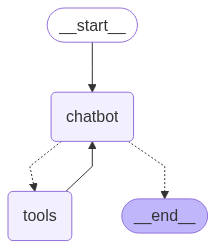

In [9]:
# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)


こんにちわ！
こんにちは！どういったことをお手伝いできますか？
1足す2は？
1足す2は3です。何か他に質問がありますか？
1メートル以上の魚は？

[{"url": "https://detail.chiebukuro.yahoo.co.jp/qa/question_detail/q14260099909", "content": "Yahoo!知恵袋\n\nJavaScriptが無効です。ブラウザの設定でJavaScriptを有効にしてください。JavaScriptを有効にするには\n\n回答受付が終了しました\n\nzka********さん\n\n2022/4/10 10:34\n\n44回答\n\n友人と琵琶湖でバス釣りをしていたら、余裕で1m以上の巨大な魚を見ました。かなり近くで見たのですが、ビワコオオナマズでも、コイでもありません。体の長さに対して太さはさほどありませんでした。\n\n友人と琵琶湖でバス釣りをしていたら、余裕で1m以上の巨大な魚を見ました。かなり近くで見たのですが、ビワコオオナマズでも、コイでもありません。体の長さに対して太さはさほどありませんでした。\n肌色に近い体色をしていました。おそらくソウギョかなぁと思いましたが、琵琶湖でソウギョ見たことある方はいますか？\r\nまた、他の魚の可能性があるとしたら、何でしょうか？\n\n釣り・1,118閲覧\n\n1人が共感しています\n\n回答（4件）\n\nwedssport205さん\n\n2022/4/11 22:46 [...] 南湖東岸エリアか天神川付近ならアオウオですね。特に水面付近でヒレ立てて泳いでりゃ間違いなくアオウオ。\n\nこの回答はいかがでしたか？ リアクションしてみよう\n\nなるほど\n\n0\n\nそうだね\n\n0\n\nありがとう\n\n0\n\nzka********さん\n\n質問者2022/4/13 14:54\n\n夏にたまに見る、沖の方でジョーズのようにセビレを出してる巨大な魚はアオウオなんですね！！ただ、体色が肌色っぽかったんですよねぇ。\n\nID非表示さん\n\n2022/4/10 17:40\n\nアリゲーターガーの可能性もあるかと。\n\nなるほど\n\n0\n\nそうだね\n\n0\n\nありがとう\n\n0\n\nzka********さ